In [1]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../")

In [216]:
from collections import defaultdict
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from gensim.models import Word2Vec, Doc2Vec

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Bidirectional, 
    LSTM, GRU, Embedding, Attention, SpatialDropout1D, GlobalMaxPooling1D, 
    GlobalAveragePooling1D, Conv1D, TimeDistributed, MaxPooling1D, Flatten
)
from tensorflow.compat.v1.keras.layers import CuDNNLSTM 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

Num GPUs Available:  1


In [4]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1



In [354]:
classes = 2
max_words = 20000
maxlen = 64
batch_size = 32
epochs = 20

In [355]:
df = pd.read_csv(f"{os.getcwd()}/../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [356]:
print(random.choice(textos))
print(len(textos))
# print(df[df['x'] == ''].index)
# print(df.loc[250])

['resposta guaxinim novo personagem' 0]
2197


In [357]:
# word_counts = defaultdict(int)
# for phrases in textos[:, 0]:
#     for word in phrases.split():
#         word_counts[word] += 1
# v_count = len(word_counts.keys())
# words_list = list(word_counts.keys())
# word_index = dict((word, i) for i, word in enumerate(words_list))

# X = []
# for phrases in textos[:, 0]:
#     xp = []
#     for word in phrases.split():
#         xp.append(word_index[word])
#     X.append(xp)
# y = textos[:, 1].astype(np.int).ravel()
# y = to_categorical(y, classes)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# tokenizer = Tokenizer(num_words=max_words)
# X_train = tokenizer.sequences_to_matrix(X_train, mode='binary')
# X_test = tokenizer.sequences_to_matrix(X_test, mode='binary')

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       270
           1       0.60      0.44      0.51       170

    accuracy                           0.67       440
   macro avg       0.65      0.63      0.63       440
weighted avg       0.66      0.67      0.66       440



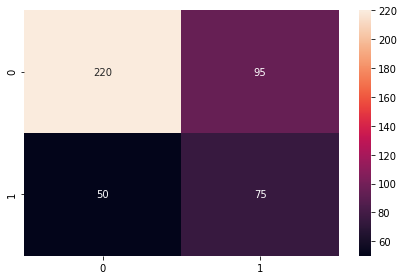

In [358]:
X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tokenizer = Tokenizer(num_words=max_words, lower=True, char_level=False)
tokenizer.fit_on_texts(X)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

clf = LogisticRegression(
    random_state=0,
    n_jobs=-1,
    max_iter=500,
    multi_class="multinomial"
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

In [359]:
X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()
y = to_categorical(y, classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tokenizer = Tokenizer(num_words=max_words, lower=True, char_level=False)
tokenizer.fit_on_texts(X)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [360]:
word_index = tokenizer.word_index

embeddings_index = {}
w2v = Word2Vec.load(f"{os.getcwd()}/../ai/models/w2v.model")

for phrase in X:
    for word in phrase.split():
        try:
            embeddings_index[word] = w2v.wv[word]
        except:
            embeddings_index[word] = np.zeros(300, )
print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 6112 word vectors.


In [361]:
X_train[0], X_test[0]

(array([2146,    2,   92,  871,   40, 1624,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([   7,  177,   83,  236, 2468,  388,    1,    4, 5214,  328,  219,
        2131, 1547,  219,  998,  766,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32))

In [367]:
model = Sequential()
model.add(Embedding(
    len(word_index) + 1, 
    output_dim=300, 
    weights=[embedding_matrix],
    trainable=False,
    input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(256, 3, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(256, 3, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(classes))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.metrics_names)

[]


In [369]:
history = model.fit(
    X_train, y_train, 
    batch_size=batch_size, 
    epochs=20, 
    verbose=0,
    shuffle=True,
    validation_data=(X_test, y_test)
)
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', round(score[1] * 100))

14/14 [==============================] - 0s 4ms/step - loss: 1.1920 - accuracy: 0.7318
Test loss: 1.1919599771499634
Test accuracy: 73


              precision    recall  f1-score   support

           0       0.73      0.89      0.80       270
           1       0.73      0.49      0.58       170

    accuracy                           0.73       440
   macro avg       0.73      0.69      0.69       440
weighted avg       0.73      0.73      0.72       440



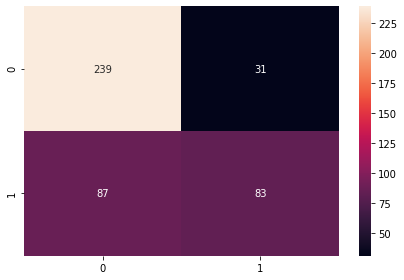

In [370]:
pred = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1)))

df_cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

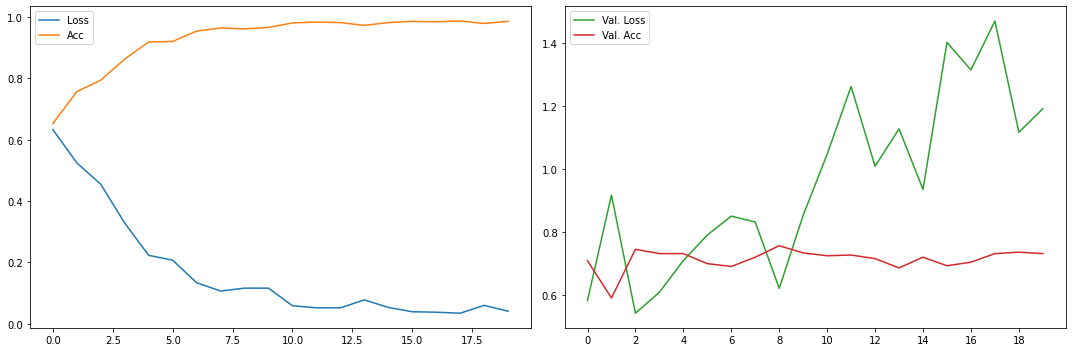

In [371]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["accuracy"], label="Acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["val_loss"], label="Val. Loss", c="C2")
plt.plot(history.history["val_accuracy"], label="Val. Acc", c="C3")
plt.xticks(range(0, epochs, 2))
plt.legend()
plt.tight_layout()
plt.show()

### Do2Vec

In [343]:
d2v = Doc2Vec.load(f"{os.getcwd()}/../ai/models/d2v.model")

n_textos = []
for texto in textos:
    doc_vec = d2v.infer_vector(texto[0].split(), epochs=500)
    n_textos.append(doc_vec)
n_textos = np.asarray(n_textos)

In [344]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()
y = to_categorical(y, classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [345]:
# # For Conv & LSTM
print(X_train.shape)
print(X_test.shape)
X_train = X_train.reshape(1757, 300, -1)
X_test = X_test.reshape(440, 300, -1)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

(1757, 300)
(440, 300)


In [350]:
model = Sequential()
model.add(Conv1D(256, 3, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(256, 3, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.metrics_names)

[]


In [351]:
history = model.fit(
    X_train, y_train, 
    batch_size=batch_size, 
    epochs=20, 
    verbose=0,
    shuffle=True,
    validation_data=(X_test, y_test)
)
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', round(score[1] * 100))

14/14 [==============================] - 0s 33ms/step - loss: 1.3763 - accuracy: 0.7000
Test loss: 1.3762774467468262
Test accuracy: 70


              precision    recall  f1-score   support

           0       0.76      0.74      0.75       270
           1       0.61      0.63      0.62       170

    accuracy                           0.70       440
   macro avg       0.68      0.69      0.69       440
weighted avg       0.70      0.70      0.70       440



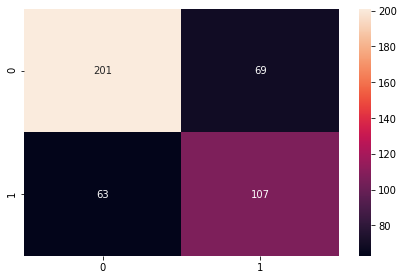

In [352]:
pred = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1)))

df_cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

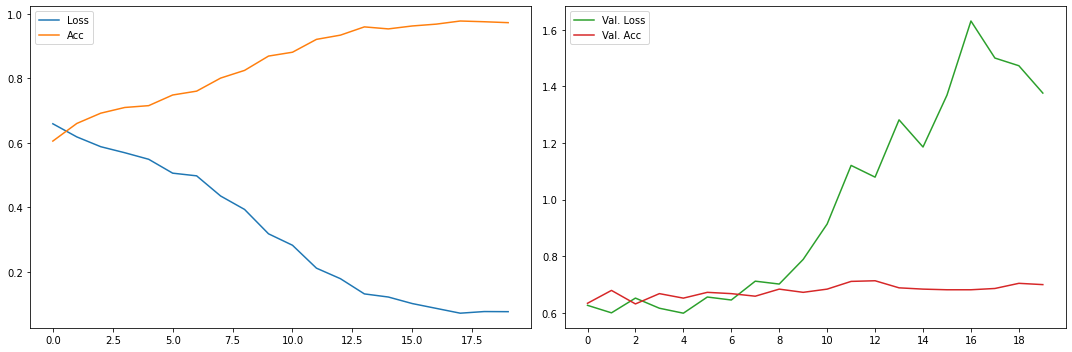

In [353]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["accuracy"], label="Acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["val_loss"], label="Val. Loss", c="C2")
plt.plot(history.history["val_accuracy"], label="Val. Acc", c="C3")
plt.xticks(range(0, epochs, 2))
plt.legend()
plt.tight_layout()
plt.show()